In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
#l1
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 5s 101us/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4626 - accuracy: 0.0996 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7919 - accuracy: 0.6193 - val_loss: 3.0346 - val_accuracy: 0.5272
Epoch 47/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.7523 - accuracy: 0.6207 - val_loss: 3.0580 - val_accuracy: 0.5158
Epoch 48/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.7103 - accuracy: 0.6250 - val_loss: 2.9809 - val_accuracy: 0.5227
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.6797 - accuracy: 0.6247 - val_loss: 2.9504 - val_accuracy: 0.5280
Epoch 50/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.6400 - accuracy: 0.6241 - val_loss: 2.9234 - val_accuracy: 0.5269
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 5s 109us/step - loss: 0.9618 - accuracy: 0.6623 - val_loss: 1.5603 - val_accuracy: 0.4770
Epoch 44/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9483 - accuracy: 0.6665 - val_loss: 1.3485 - val_accuracy: 0.5311
Epoch 45/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9336 - accuracy: 0.6736 - val_loss: 1.3806 - val_accuracy: 0.5237
Epoch 46/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9222 - accuracy: 0.6753 - val_loss: 1.4395 - val_accuracy: 0.5224
Epoch 47/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9125 - accuracy: 0.6799 - val_loss: 1.3953 - val_accuracy: 0.5256
Epoch 48/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.8984 - accuracy: 0.6860 - val_loss: 1.6073 - val_accuracy: 0.4882
Epoch 49/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.8967 - accuracy: 0.6863 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.9790 - accuracy: 0.6547 - val_loss: 1.4814 - val_accuracy: 0.4976
Epoch 42/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.9657 - accuracy: 0.6595 - val_loss: 1.3738 - val_accuracy: 0.5207
Epoch 43/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.9557 - accuracy: 0.6628 - val_loss: 1.3610 - val_accuracy: 0.5304
Epoch 44/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.9441 - accuracy: 0.6682 - val_loss: 1.3484 - val_accuracy: 0.5317
Epoch 45/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.9271 - accuracy: 0.6747 - val_loss: 1.3739 - val_accuracy: 0.5295
Epoch 46/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.9178 - accuracy: 0.6772 - val_loss: 1.3591 - val_accuracy: 0.5307
Epoch 47/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.9047 - accuracy: 0.6828 - val_

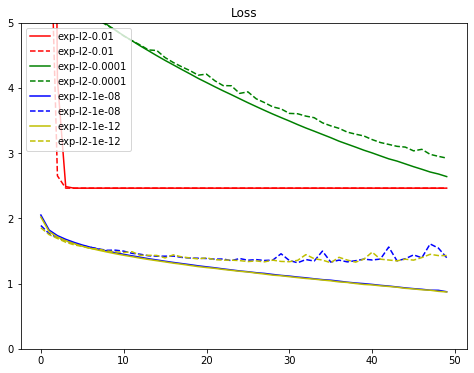

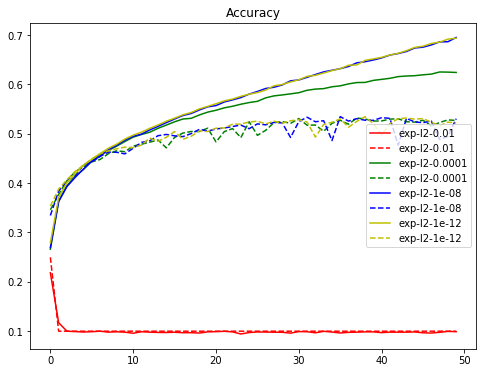

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
#l1_l2
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 5s 110us/step - loss: 2.4614 - accuracy: 0.0981 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.4614 - accuracy: 0.0986 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.4614 - accuracy: 0.0961 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 6s 120us/step - loss: 1.7710 - accuracy: 0.4783 - val_loss: 1.8142 - val_accuracy: 0.4611
Epoch 46/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7668 - accuracy: 0.4813 - val_loss: 1.8221 - val_accuracy: 0.4566
Epoch 47/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.7639 - accuracy: 0.4808 - val_loss: 1.7902 - val_accuracy: 0.4730
Epoch 48/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7590 - accuracy: 0.4818 - val_loss: 1.8192 - val_accuracy: 0.4572
Epoch 49/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7562 - accuracy: 0.4815 - val_loss: 1.7855 - val_accuracy: 0.4707
Epoch 50/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.7553 - accuracy: 0.4825 - val_loss: 1.7819 - val_accuracy: 0.4714
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6415 - accuracy: 0.5145 - val_loss: 1.7151 - val_accuracy: 0.4930
Epoch 44/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6356 - accuracy: 0.5173 - val_loss: 1.6894 - val_accuracy: 0.4962
Epoch 45/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6324 - accuracy: 0.5155 - val_loss: 1.6898 - val_accuracy: 0.4857
Epoch 46/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6273 - accuracy: 0.5166 - val_loss: 1.7500 - val_accuracy: 0.4689
Epoch 47/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6248 - accuracy: 0.5178 - val_loss: 1.7648 - val_accuracy: 0.4555
Epoch 48/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6198 - accuracy: 0.5195 - val_loss: 1.7151 - val_accuracy: 0.4737
Epoch 49/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6170 - accuracy: 0.5200

50000/50000 [==============================] - 6s 117us/step - loss: 1.6599 - accuracy: 0.5104 - val_loss: 1.7025 - val_accuracy: 0.4946
Epoch 41/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.6515 - accuracy: 0.5141 - val_loss: 1.7210 - val_accuracy: 0.4891
Epoch 42/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6447 - accuracy: 0.5158 - val_loss: 1.6977 - val_accuracy: 0.4961
Epoch 43/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6402 - accuracy: 0.5153 - val_loss: 1.6811 - val_accuracy: 0.5011
Epoch 44/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6333 - accuracy: 0.5181 - val_loss: 1.6893 - val_accuracy: 0.4962
Epoch 45/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.6295 - accuracy: 0.5176 - val_loss: 1.6853 - val_accuracy: 0.4975
Epoch 46/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6260 - accuracy: 0.5200 - val_loss:

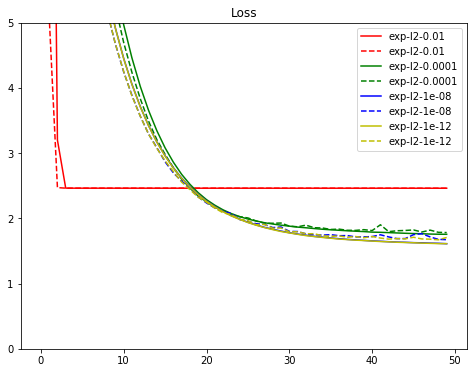

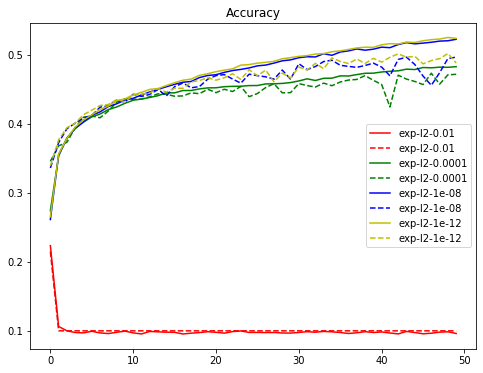

In [11]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()